In [13]:
%load_ext autoreload
%autoreload 2
import utils; utils.setup()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

import visualization
import data
import finance

In [15]:
from pathlib import Path
project_root = Path().resolve().parent

intervals = data.intervals



In [16]:
raw_interval = '15m'
interval = '1h'

raw_data_1min = data.load_symbol('solusdt', dir=project_root, interval=raw_interval)


In [17]:
df = data.set_interval(raw_data_1min, intervals[interval])
samples = df.shape[0]

/home/jbc/Work/indi/matplotlib-visualization-lib/src/data/__init__.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  out['data_points']  = grouper['data_points'].sum()


In [18]:
periods = 8

close = df['close'].to_numpy()[:-periods]
close = close * np.ones((periods, len(close)))
close = close.T

rolling = {
    'high': (pd.DataFrame([window.to_list() for window in df['high'].rolling(periods)], index=df.index).dropna()[1:] - close) / close,
    'low':  (pd.DataFrame([window.to_list() for window in df['low'] .rolling(periods)], index=df.index).dropna()[1:] - close) / close,
}


In [19]:
what = 'high'
g = 0.02

predicate = (g < rolling[what]).any(axis=1)

high = rolling[what]
gain = high[predicate]
loss = high[predicate.apply(lambda x: not x)]
len(gain), len(loss), samples


(1508, 5262, 6778)

Text(0.5, 1.0, 'min waiting period (looks like poison dist.)')

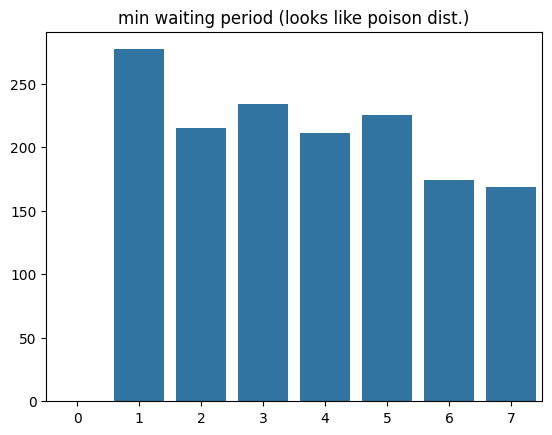

In [20]:
arr = (g < rolling[what]) * np.array([np.arange(periods) for _ in range(len(predicate))])
arr[arr == 0] = np.nan
first_t = arr.min(axis=1).dropna().astype(int)
holding_period, unique = np.unique(first_t, return_counts=True)
counts = np.zeros(int(arr.min().min()))
counts = np.append(counts, unique)
axs = sns.barplot(counts)
axs.set_title('min waiting period (looks like poison dist.)')


It looks like a Poison distribution

Text(0.5, 1.0, 'hit rate of 1508 (22.2%) possible wins above g = 2.0% by waiting period')

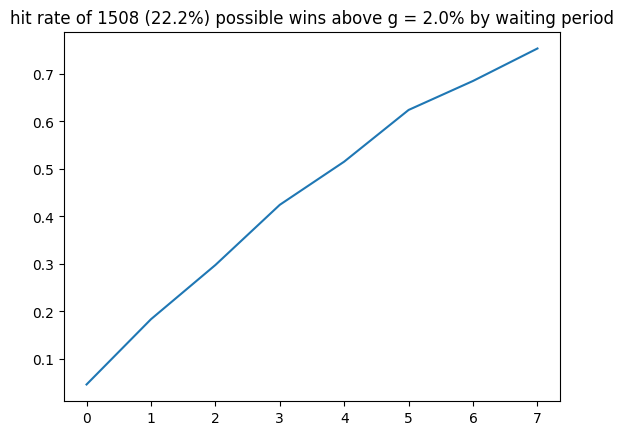

In [21]:
gain_len = len(gain)
gain_sum = (gain > g).sum(0)
gain_avg = gain_sum / gain_len
axs = sns.lineplot(gain_avg)
axs.set_title(f'hit rate of {gain_len} ({finance.perc(gain_len, samples)}%) possible wins above g = {finance.perc(g)}% by waiting period')

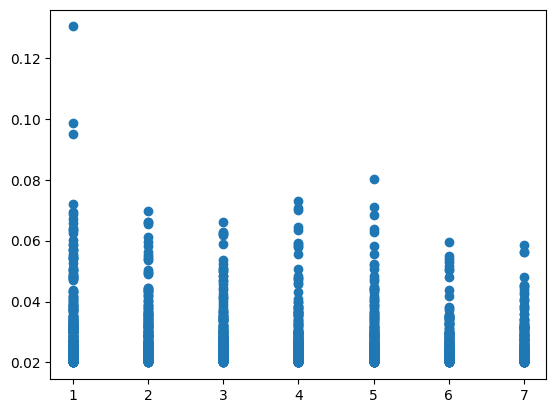

In [22]:
selected = high.loc[first_t.index]
profit = np.array([(selected[t].iloc[idx], t) for idx, t in enumerate(first_t)]).T
plt.plot(profit[1], profit[0], 'o')

<Axes: >

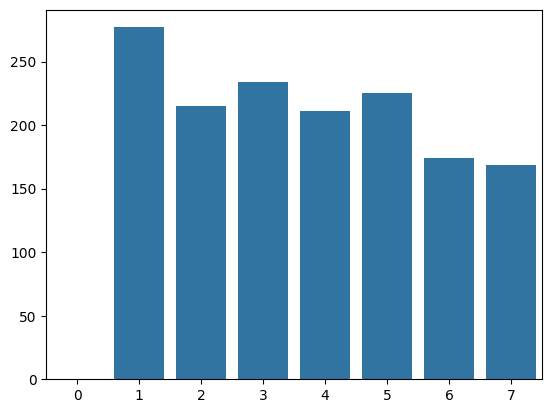

In [23]:
sns.barplot([np.sum(profit[1] == t) for t in np.arange(periods)])